# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error,mean_squared_error
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,PowerTransformer
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from scipy.stats import spearmanr
import tensorflow as tf
import statsmodels.stats.api as sms
import statsmodels.regression.linear_model as smf
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn import datasets
from sklearn.metrics import silhouette_score
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','리그','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
midfielder_df = fm_data_df[fm_data_df['포지션']=='미드필더']
midfielder_df = midfielder_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [midfielder_df.columns[i] for i,x in enumerate(midfielder_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
midfielder_df.isna().sum()

이름              0
포지션             0
리그              0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
승               0
무               0
패               0
시즌              0
구단              0
dtype: int64

## 변수 별 분포 확인

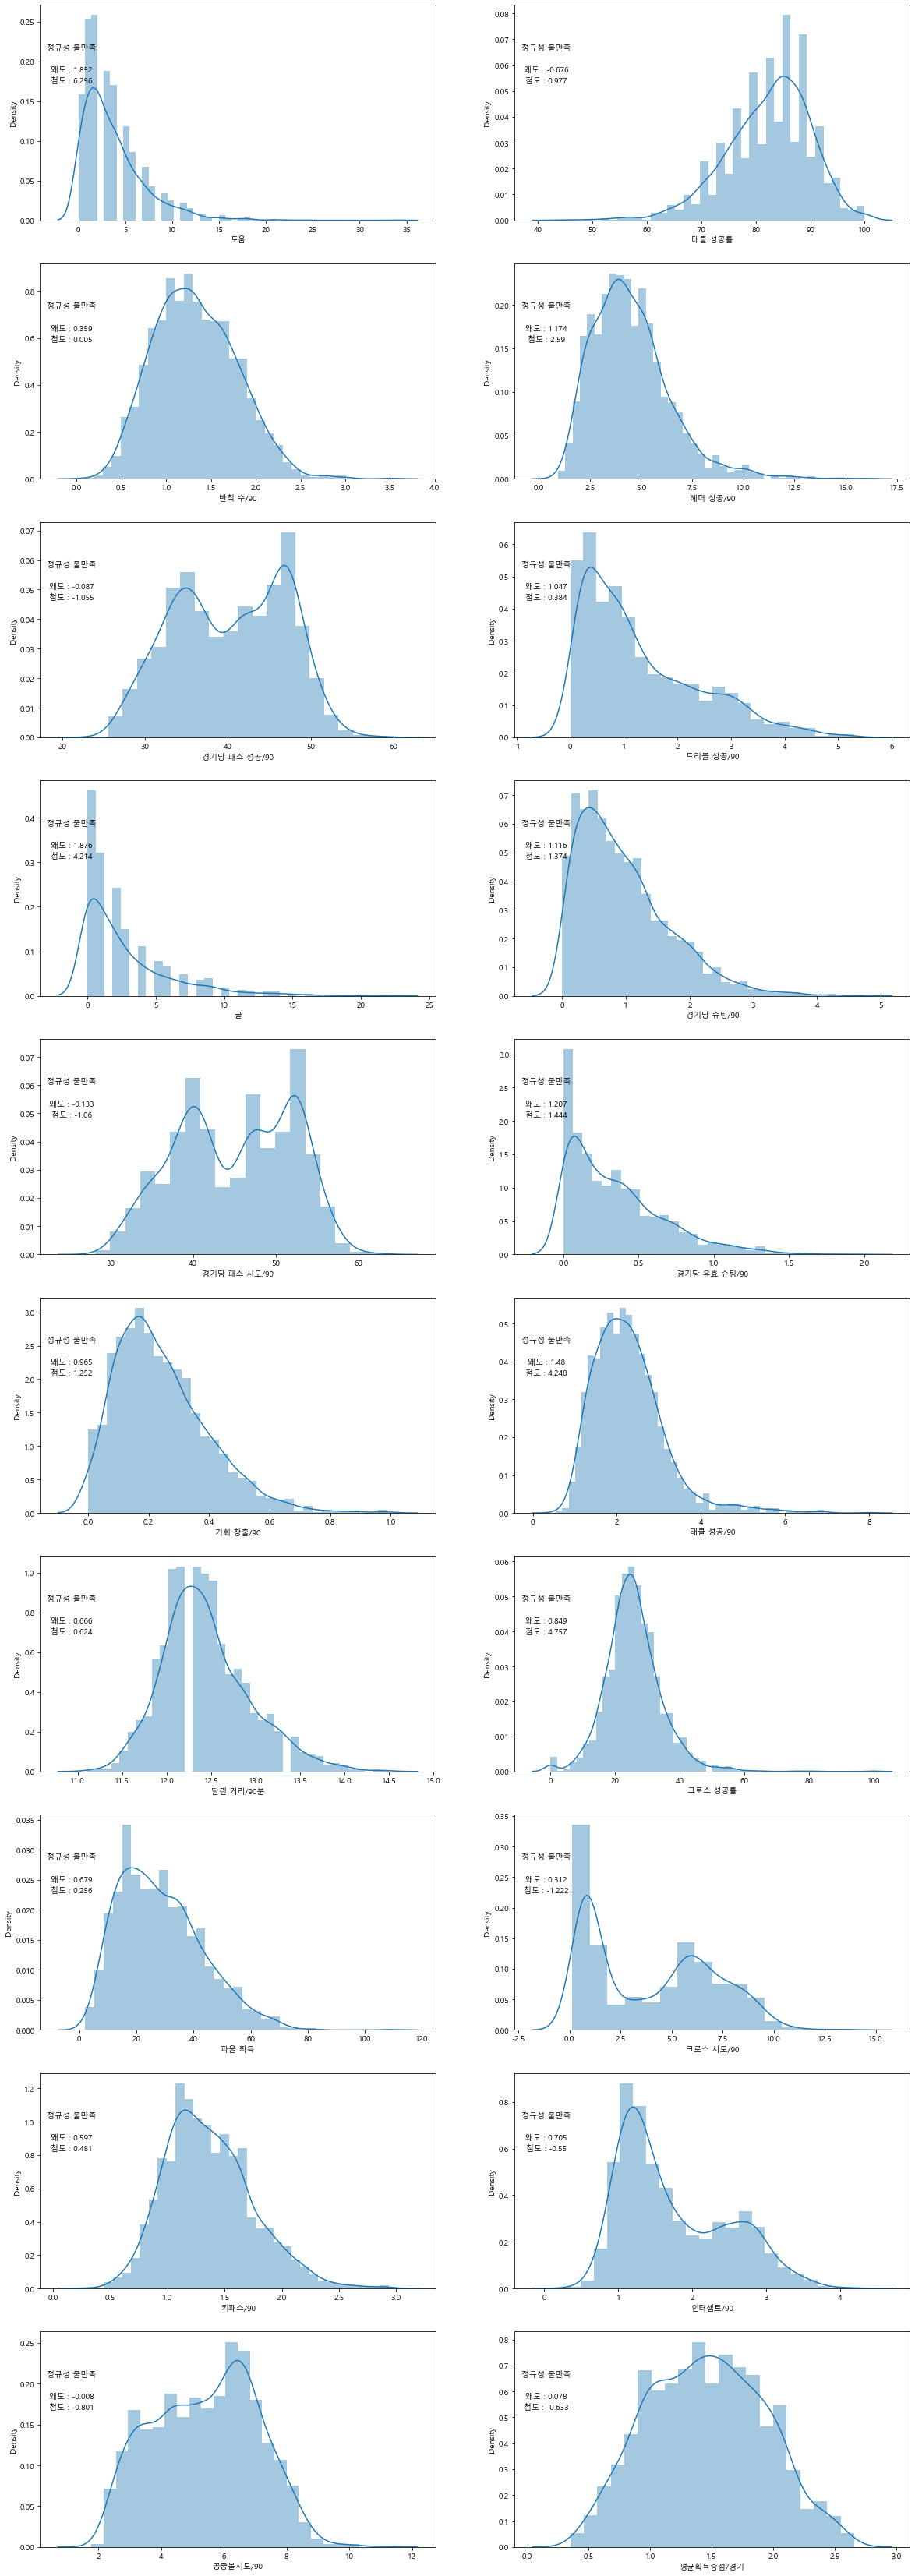

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = midfielder_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = midfielder_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

## 선형성 검정

모든 변수 선형성 만족

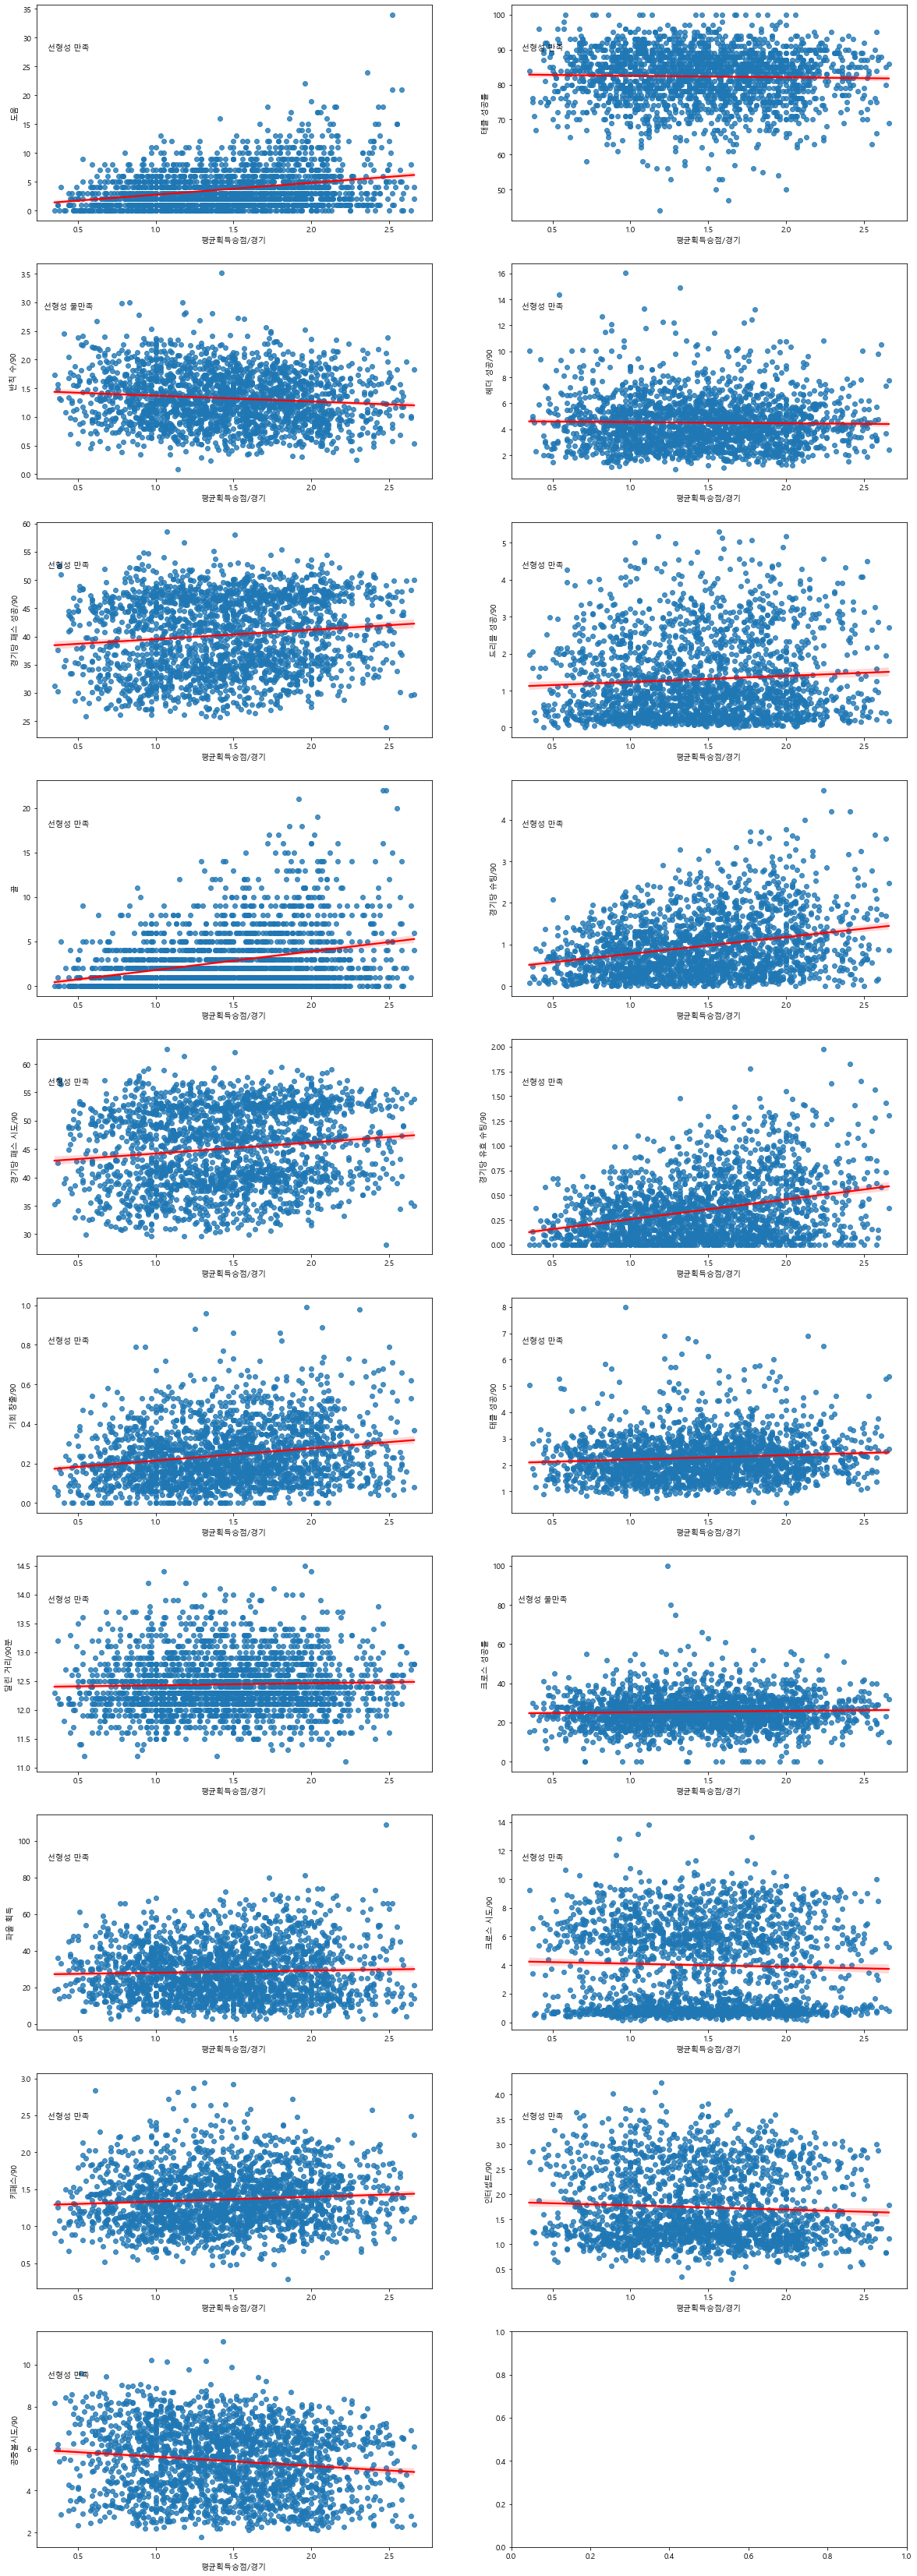

In [6]:
figs , axes = plt.subplots(10,2,figsize=(20,60))


# 독립변수 시각화
for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    sns.regplot(x=dependent_value,y=feature,data=midfielder_df,line_kws={'color': 'red'},ax=ax)
    model = smf.OLS(midfielder_df[dependent_value],midfielder_df[feature]).fit()
    lin_p = sms.linear_rainbow(model,frac=0.5)[1]
    if lin_p>= 0.1: 
        ax.text(x=0.08,y=0.8,s='선형성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='선형성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

## 이상치 탐지

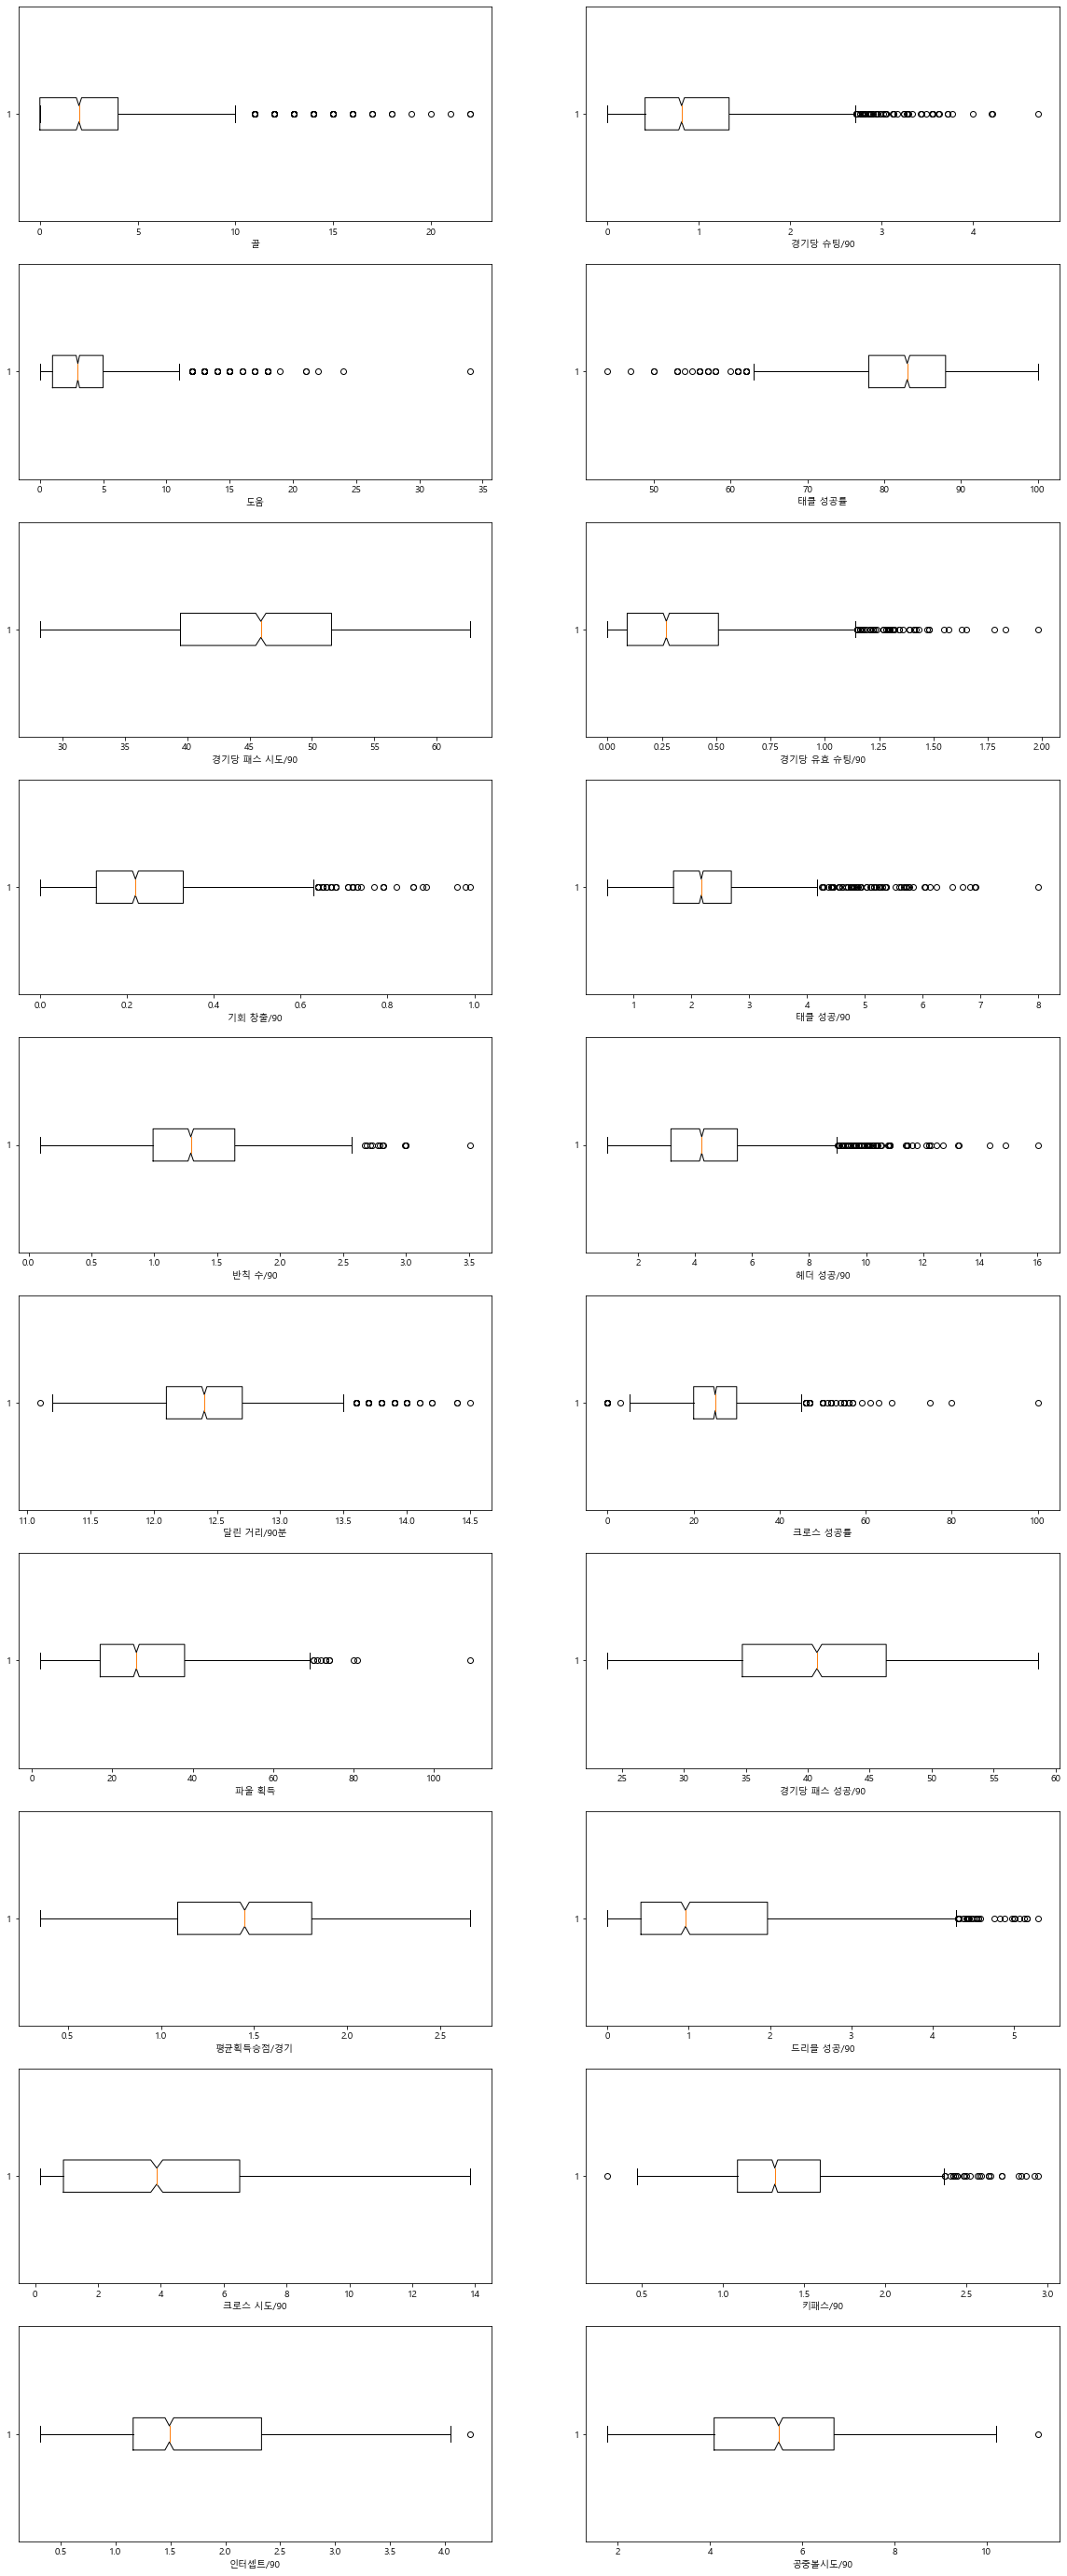

In [7]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value | set([dependent_value]))) :
    ax.set_xlabel(feature)
    ax.boxplot(midfielder_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [8]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = midfielder_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/len(midfielder_df)*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 {len(midfielder_df)}개의 데이터 중 {len(total)} 개 입니다.')

도움중 이상치는 68개 비율은 약 3.164% 입니다

태클 성공률중 이상치는 46개 비율은 약 2.141% 입니다

반칙 수/90중 이상치는 20개 비율은 약 0.931% 입니다

헤더 성공/90중 이상치는 92개 비율은 약 4.281% 입니다

경기당 패스 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

드리블 성공/90중 이상치는 84개 비율은 약 3.909% 입니다

골중 이상치는 207개 비율은 약 9.632% 입니다

경기당 슈팅/90중 이상치는 88개 비율은 약 4.095% 입니다

경기당 패스 시도/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 유효 슈팅/90중 이상치는 96개 비율은 약 4.467% 입니다

기회 창출/90중 이상치는 80개 비율은 약 3.723% 입니다

태클 성공/90중 이상치는 91개 비율은 약 4.235% 입니다

달린 거리/90분중 이상치는 122개 비율은 약 5.677% 입니다

크로스 성공률중 이상치는 89개 비율은 약 4.141% 입니다

파울 획득중 이상치는 45개 비율은 약 2.094% 입니다

크로스 시도/90중 이상치는 1개 비율은 약 0.047% 입니다

키패스/90중 이상치는 52개 비율은 약 2.42% 입니다

인터셉트/90중 이상치는 19개 비율은 약 0.884% 입니다

공중볼시도/90중 이상치는 4개 비율은 약 0.186% 입니다

이상치가 있는 row의 갯수는 총 2149개의 데이터 중 782 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인 - 독립성 검정

### 상관계수

#### 상관계수 시각화

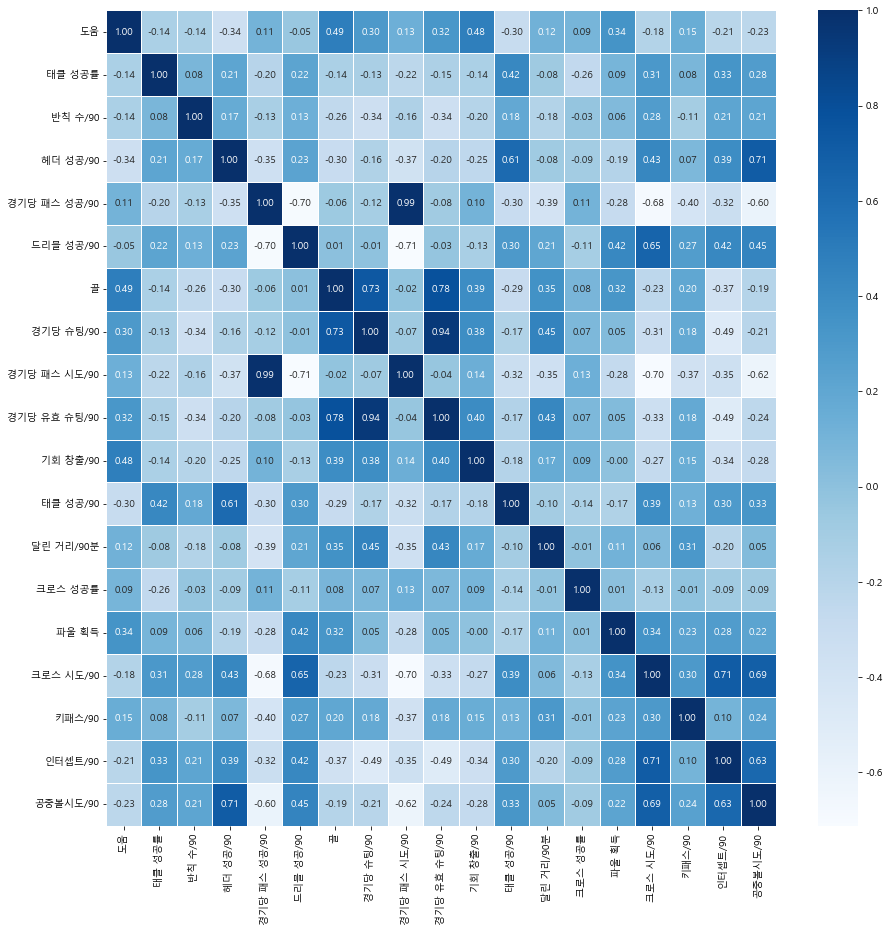

In [9]:
plt.figure(figsize=(15,15))
sns.heatmap(data = midfielder_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues');

#### 독립변수 간 상관계수가 0.9이상인 변수들

In [10]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(midfielder_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 패스 성공/90,경기당 패스 시도/90,0.989254
1,경기당 슈팅/90,경기당 유효 슈팅/90,0.934824


## 상관계수, 다중 공선성

In [11]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(midfielder_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수']).head(20)

,종속변수,독립변수,상관계수
0,골,평균획득승점/경기,0.261017
1,경기당 유효 슈팅/90,평균획득승점/경기,0.254368
2,도움,평균획득승점/경기,0.252083
3,경기당 슈팅/90,평균획득승점/경기,0.233739
4,기회 창출/90,평균획득승점/경기,0.180045
5,경기당 패스 시도/90,평균획득승점/경기,0.135242
6,경기당 패스 성공/90,평균획득승점/경기,0.122175
7,공중볼시도/90,평균획득승점/경기,-0.120752
8,반칙 수/90,평균획득승점/경기,-0.094767
9,태클 성공/90,평균획득승점/경기,0.094151


In [12]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(midfielder_df.loc[:,independent_value].values,i) for i in range(midfielder_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = midfielder_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,3.951155,도움
1,5.424681,기회 창출/90
2,6.238692,골
3,6.262178,드리블 성공/90
4,10.487262,파울 획득
5,10.526453,크로스 성공률
6,11.307189,반칙 수/90
7,12.766822,크로스 시도/90
8,20.437991,키패스/90
9,20.499194,태클 성공/90


## EDA Summary


- 모든 독립변수는 선형성을 만족한다.
- 이상치가 있는 row를 모두 삭제한다면 data loss가 너무 크므로 이상치에 강건한 스케일링을 활용해야 한다.
- 상관계수가 높은 독립변수간 상관관계제거, 다중공선성 해결 필요

# 데이터 전처리

## 전처리 중간중간 쓰일 함수

In [13]:
def check_vif(independent_value):
    this_vif = pd.DataFrame()
    this_vif["VIF 계수"] = [vif(midfielder_df.loc[:,independent_value].values,i) for i in range(midfielder_df.loc[:,independent_value].values.shape[1])]
    this_vif["종속변수"] = midfielder_df.loc[:,independent_value].columns
    this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
    return this_vif

In [14]:
def check_indepen_high_corr(independent_value):
    # 상관계수의 절대값이 0.7 이상인것들
    high_corr_list = []
    feature_comb = list(combinations(independent_value,2))
    corr_dict_pair = {}

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for a,b in feature_comb:
        spearmann = spearmanr(midfielder_df[[a,b]])
        corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
        if spearmann[0] >= 0.9 or spearmann[0] <= -0.9:
            high_corr_list.append([a,b,spearmann[0]])

    return pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

In [15]:
def check_dependent_corr(independent_value):
    corr_dict_dependent = {}
    corr_list_dependent = []

    # 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
    for val in independent_value:
        spearmann = spearmanr(midfielder_df[[val,dependent_value]])
        corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
        corr_list_dependent.append([val,dependent_value,spearmann[0]])

    df = pd.DataFrame(sorted(corr_list_dependent,key=lambda x : np.abs(x[2]),reverse=True),columns=['종속변수','독립변수','상관계수'])
    return df

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

1. 골,경기당 슈팅, 유효 슈팅
2. 도움, 패스시도,패스성공,키패스
3. 태클 성공률, 태클 성공/90
4. 공중볼 시도, 헤더성공
5. 드리블 시도
6. 인터셉트/90
7. 크로스시도 크로스 성공
8. 파울 획득
9. 반칙 수 /90
10. 달린거리/90분

### 골과 경기당 슈팅, 유효슈팅

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [16]:
midfielder_df[['골','경기당 유효 슈팅/90','경기당 슈팅/90','평균획득승점/경기']].corr()

,골,경기당 유효 슈팅/90,경기당 슈팅/90,평균획득승점/경기
골,1.000000,0.780039,0.732572,0.299445
경기당 유효 슈팅/90,0.780039,1.000000,0.937607,0.300244
경기당 슈팅/90,0.732572,0.937607,1.000000,0.268271
평균획득승점/경기,0.299445,0.300244,0.268271,1.000000


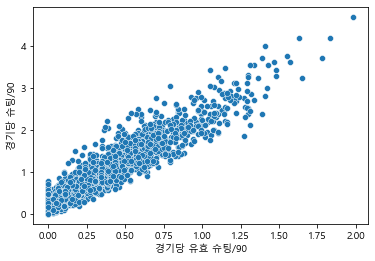

In [17]:
sns.scatterplot(x='경기당 유효 슈팅/90',y='경기당 슈팅/90',data=midfielder_df);

#### 피쳐 엔지니어링

In [18]:
# Goal_Shoot_linear
midfielder_df['GSL'] = (midfielder_df['경기당 유효 슈팅/90']+0.5) + (midfielder_df['경기당 슈팅/90']) + (midfielder_df['골']*1.3)

independent_value.add('GSL')
independent_value = independent_value - set(['골','경기당 슈팅/90','경기당 유효 슈팅/90'])

midfielder_df[['이름','GSL']].sort_values(by='GSL',ascending=False).head()

,이름,GSL
1171,João Félix,33.99
1975,Kai Havertz,32.78
153,Nabil Fekir,31.85
1172,Bernardo Silva,30.43
1131,Neymar,30.29


#### 상관계수 확인 (통과)

In [19]:
midfielder_df[['GSL','평균획득승점/경기']].corr()

,GSL,평균획득승점/경기
GSL,1.000000,0.307853
평균획득승점/경기,0.307853,1.000000


In [20]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.905105,도움
1,4.309841,GSL
2,5.383943,기회 창출/90
3,6.218769,드리블 성공/90
4,10.183189,파울 획득
5,10.524237,크로스 성공률
6,11.008547,반칙 수/90
7,12.457073,크로스 시도/90
8,20.355060,태클 성공/90
9,20.430291,키패스/90


In [21]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수
0,경기당 패스 시도/90,경기당 패스 성공/90,0.989254


### 경기당 패스 성공/90 경기당 패스 시도/90

#### 종속변수와 상관계수 확인(목표: 상관계수간 평균보다 높은 피쳐를 만들자)

In [22]:
midfielder_df[['경기당 패스 성공/90','경기당 패스 시도/90','평균획득승점/경기']].corr()

,경기당 패스 성공/90,경기당 패스 시도/90,평균획득승점/경기
경기당 패스 성공/90,1.000000,0.991228,0.117450
경기당 패스 시도/90,0.991228,1.000000,0.132325
평균획득승점/경기,0.117450,0.132325,1.000000


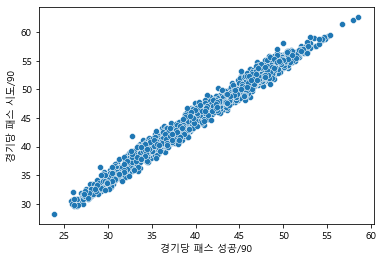

In [23]:
sns.scatterplot(x='경기당 패스 성공/90',y='경기당 패스 시도/90',data=midfielder_df);

#### 피쳐 엔지니어링

In [24]:
# PSTL = Pass sucess try linear

midfielder_df['PSTL'] = (midfielder_df['경기당 패스 성공/90']) + (midfielder_df['경기당 패스 시도/90'])*1.15

independent_value.add('PSTL')
independent_value = independent_value - set(['경기당 패스 성공/90','경기당 패스 시도/90'])

midfielder_df[['이름','PSTL']].sort_values(by='PSTL',ascending=False).head()

,이름,PSTL
703,Ivan Ilić,130.6420
595,Danilo Cataldi,129.3520
1337,Davide Frattesi,127.2440
889,Frenkie de Jong,123.7935
360,Otávio,123.2950


#### 상관계수 확인 (통과)

In [25]:
midfielder_df[['PSTL','평균획득승점/경기']].corr()

,PSTL,평균획득승점/경기
PSTL,1.00000,0.12582
평균획득승점/경기,0.12582,1.00000


In [26]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.903997,도움
1,4.262385,GSL
2,5.371990,기회 창출/90
3,6.179896,드리블 성공/90
4,10.181397,파울 획득
5,10.340677,크로스 성공률
6,10.964986,반칙 수/90
7,12.387468,크로스 시도/90
8,19.128185,키패스/90
9,20.334087,태클 성공/90


### 피쳐 삭제

In [27]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '인터셉트/90',
 '크로스 성공률',
 '크로스 시도/90',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '헤더 성공/90'}

In [28]:
independent_value = independent_value - set(['달린 거리/90분','태클 성공률','헤더 성공/90','크로스 시도/90','인터셉트/90','파울 획득','크로스 성공률'])

In [29]:
check_dependent_corr(independent_value)

,종속변수,독립변수,상관계수
0,GSL,평균획득승점/경기,0.266542
1,도움,평균획득승점/경기,0.252083
2,기회 창출/90,평균획득승점/경기,0.180045
3,PSTL,평균획득승점/경기,0.130185
4,공중볼시도/90,평균획득승점/경기,-0.120752
5,반칙 수/90,평균획득승점/경기,-0.094767
6,태클 성공/90,평균획득승점/경기,0.094151
7,키패스/90,평균획득승점/경기,0.093502
8,드리블 성공/90,평균획득승점/경기,0.057785


In [30]:
check_vif(independent_value)

,VIF 계수,종속변수
0,3.086890,GSL
1,3.488176,도움
2,3.962406,드리블 성공/90
3,5.068278,기회 창출/90
4,10.090085,반칙 수/90
5,10.216182,태클 성공/90
6,15.388208,공중볼시도/90
7,15.734364,키패스/90
8,17.216284,PSTL


In [31]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '키패스/90',
 '태클 성공/90'}

In [32]:
check_indepen_high_corr(independent_value)

,변수 1,변수 2,상관계수


### 최종 종속변수

In [33]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '키패스/90',
 '태클 성공/90'}

In [34]:
midfielder_df.columns

Index(['이름', '포지션', '리그', '골', '도움', '경기당 팀 득점/90', '경기당 팀 실점/90', '크로스 성공률',
       '파울 획득', '반칙 수/90', '기회 창출/90', '경기당 유효 슈팅/90', '경기당 슈팅/90', '인터셉트/90',
       '달린 거리/90분', '공중볼시도/90', '태클 성공률', '경기당 패스 시도/90', '경기당 패스 성공/90',
       '키패스/90', '태클 성공/90', '드리블 성공/90', '헤더 성공/90', '크로스 시도/90', '평균획득승점/경기',
       '승', '무', '패', '시즌', '구단', 'GSL', 'PSTL'],
      dtype='object')

## 이상치 처리

이상치를 제외하면 데이터 손실이 너무 크기 때문에 Quantile transform을 사용해서 이상치를 고려한 normalization을 진행하기로 함.

## 데이터 정규화

In [35]:
x_train,x_test,y_train,y_test = train_test_split(midfielder_df.loc[:,independent_value],midfielder_df.loc[:,dependent_value])

midfielder_x_po = RobustScaler().fit(x_train.loc[:,independent_value])

x_train.loc[:,independent_value] = midfielder_x_po.transform(x_train.loc[:,independent_value])
x_test.loc[:,independent_value] = midfielder_x_po.transform(x_test.loc[:,independent_value])

# 모델 생성

In [36]:
inputs_layer = Input(shape=(len(independent_value),))
hidden1 = Dense(10,activation='relu')(inputs_layer)
hidden2 = Dense(128,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden1)
hidden3 = Dense(128,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden2)
hidden4 = Dense(10,activation='relu',kernel_regularizer=L2(l2=0.01))(hidden3)
output = Dense(1,activation='linear',kernel_regularizer=L2(l2=0.01))(hidden4)
model = Model(inputs=[inputs_layer],outputs=[output])
model.compile(loss='mse',optimizer=Adam(lr=0.001))
     
model.fit(x_train.loc[:,independent_value],y_train,batch_size=100,epochs=500,validation_data=(x_test.loc[:,independent_value],y_test))  
predict_result=model.predict(x_test.loc[:,independent_value])
mae = mean_absolute_error(y_test,predict_result)

Epoch 1/500
17/17 [==============================] - 0s 9ms/step - loss: 2.9108 - val_loss: 1.8898
Epoch 2/500
17/17 [==============================] - 0s 1ms/step - loss: 1.7556 - val_loss: 1.5834
Epoch 3/500
17/17 [==============================] - 0s 2ms/step - loss: 1.4417 - val_loss: 1.3295
Epoch 4/500
17/17 [==============================] - 0s 1ms/step - loss: 1.2097 - val_loss: 1.1321
Epoch 5/500
17/17 [==============================] - 0s 1ms/step - loss: 1.0318 - val_loss: 0.9762
Epoch 6/500
17/17 [==============================] - 0s 2ms/step - loss: 0.8893 - val_loss: 0.8472
Epoch 7/500
17/17 [==============================] - 0s 2ms/step - loss: 0.7746 - val_loss: 0.7438
Epoch 8/500
17/17 [==============================] - 0s 2ms/step - loss: 0.6839 - val_loss: 0.6611
Epoch 9/500
17/17 [==============================] - 0s 1ms/step - loss: 0.6129 - val_loss: 0.5969
Epoch 10/500
17/17 [==============================] - 0s 1ms/step - loss: 0.5539 - val_loss: 0.5423
Epoch 11/

17/17 [==============================] - 0s 1ms/step - loss: 0.1921 - val_loss: 0.2014
Epoch 84/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1922 - val_loss: 0.2027
Epoch 85/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1925 - val_loss: 0.2013
Epoch 86/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1911 - val_loss: 0.2011
Epoch 87/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1909 - val_loss: 0.2055
Epoch 88/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1922 - val_loss: 0.2034
Epoch 89/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1918 - val_loss: 0.2010
Epoch 90/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1913 - val_loss: 0.2002
Epoch 91/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1901 - val_loss: 0.1997
Epoch 92/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1907 - val_loss: 0.1997
Epoch 93/500


17/17 [==============================] - 0s 1ms/step - loss: 0.1850 - val_loss: 0.1952
Epoch 165/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1834 - val_loss: 0.1951
Epoch 166/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1826 - val_loss: 0.1951
Epoch 167/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1832 - val_loss: 0.1949
Epoch 168/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1832 - val_loss: 0.1943
Epoch 169/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1825 - val_loss: 0.1949
Epoch 170/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1828 - val_loss: 0.1964
Epoch 171/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1843 - val_loss: 0.1976
Epoch 172/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1828 - val_loss: 0.1958
Epoch 173/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1827 - val_loss: 0.2000
Epoc

17/17 [==============================] - 0s 1ms/step - loss: 0.1802 - val_loss: 0.1926
Epoch 246/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1800 - val_loss: 0.1928
Epoch 247/500
17/17 [==============================] - 0s 4ms/step - loss: 0.1801 - val_loss: 0.1927
Epoch 248/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1818 - val_loss: 0.1921
Epoch 249/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1797 - val_loss: 0.1925
Epoch 250/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1797 - val_loss: 0.1927
Epoch 251/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1793 - val_loss: 0.1923
Epoch 252/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1795 - val_loss: 0.1925
Epoch 253/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1796 - val_loss: 0.1919
Epoch 254/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1793 - val_loss: 0.1919
Epoc

17/17 [==============================] - 0s 1ms/step - loss: 0.1781 - val_loss: 0.1950
Epoch 327/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1777 - val_loss: 0.1904
Epoch 328/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1780 - val_loss: 0.1897
Epoch 329/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1800 - val_loss: 0.1905
Epoch 330/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1776 - val_loss: 0.1907
Epoch 331/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1764 - val_loss: 0.1898
Epoch 332/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1777 - val_loss: 0.1899
Epoch 333/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1767 - val_loss: 0.1903
Epoch 334/500
17/17 [==============================] - 0s 2ms/step - loss: 0.1765 - val_loss: 0.1968
Epoch 335/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1786 - val_loss: 0.1903
Epoc

17/17 [==============================] - 0s 1ms/step - loss: 0.1755 - val_loss: 0.1882
Epoch 408/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1753 - val_loss: 0.1879
Epoch 409/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.1898
Epoch 410/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1743 - val_loss: 0.1889
Epoch 411/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1753 - val_loss: 0.1885
Epoch 412/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1752 - val_loss: 0.1898
Epoch 413/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1751 - val_loss: 0.1911
Epoch 414/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1756 - val_loss: 0.1892
Epoch 415/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.1888
Epoch 416/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.1883
Epoc

17/17 [==============================] - 0s 1ms/step - loss: 0.1735 - val_loss: 0.1867
Epoch 489/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1754 - val_loss: 0.1871
Epoch 490/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1736 - val_loss: 0.1887
Epoch 491/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1737 - val_loss: 0.1870
Epoch 492/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1739 - val_loss: 0.1874
Epoch 493/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1742 - val_loss: 0.1866
Epoch 494/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1747 - val_loss: 0.1868
Epoch 495/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1739 - val_loss: 0.1873
Epoch 496/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1732 - val_loss: 0.1865
Epoch 497/500
17/17 [==============================] - 0s 1ms/step - loss: 0.1739 - val_loss: 0.1873
Epoc

In [37]:
mae

0.3288061171038887

In [38]:
independent_value

{'GSL',
 'PSTL',
 '공중볼시도/90',
 '기회 창출/90',
 '도움',
 '드리블 성공/90',
 '반칙 수/90',
 '키패스/90',
 '태클 성공/90'}

In [39]:
midfielder_df.loc[:,independent_value] = midfielder_x_po.transform(midfielder_df.loc[:,independent_value])

In [40]:
y_pred = model.predict(midfielder_df.loc[:,independent_value])

In [41]:
midfielder_df['예측_PPG'] = y_pred

In [42]:
midfielder_df.sort_values(by='예측_PPG').head()

,이름,포지션,리그,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,...,크로스 시도/90,평균획득승점/경기,승,무,패,시즌,구단,GSL,PSTL,예측_PPG
1364,Samú,미드필더,이탈리아 세리에 A,0,-0.25,0.87,1.03,80.0,13,-1.061538,...,0.27,1.26,7.0,3.0,9.0,2022-2023,우디네세,-0.427152,0.582361,1.044093
2048,Gabriel Sara,미드필더,이탈리아 세리에 A,2,-0.75,0.62,1.54,16.0,24,1.061538,...,1.45,0.68,5.0,8.0,21.0,2023-2024,베네벤토,-0.009934,0.210089,1.044107
2037,Fabio Maistro,미드필더,이탈리아 세리에 A,0,0.00,0.54,1.81,41.0,29,1.169231,...,0.36,0.44,4.0,4.0,28.0,2023-2024,레지나,-0.443709,0.300569,1.044147
379,Yvan Neyou,미드필더,프랑스 리그 1,0,-0.25,1.00,1.87,32.0,22,-0.276923,...,1.83,1.11,9.0,4.0,15.0,2021-2022,AS 생테티엔,-0.470199,0.214368,1.044153
1452,Niklas Dorsch,미드필더,독일 분데스리가,1,0.00,1.58,2.50,16.0,12,0.061538,...,1.00,1.17,4.0,2.0,6.0,2023-2024,뒤셀도르프,-0.120861,0.559600,1.044162


# 모델검정

In [43]:
residual = midfielder_df['평균획득승점/경기'] - midfielder_df['예측_PPG']

## 잔차의 정규성 검정

In [44]:
# 정규성 만족
stats.shapiro(residual)

ShapiroResult(statistic=0.9976948499679565, pvalue=0.003151120152324438)

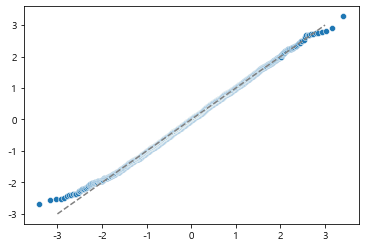

In [45]:
sr = stats.zscore(residual)
(x, y), _ = stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey');

## 잔차의 등분산성 검정

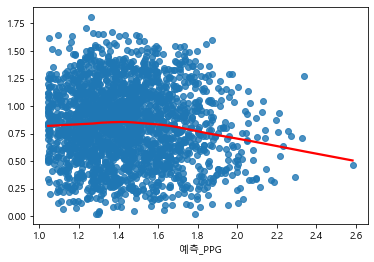

In [46]:
sns.regplot(midfielder_df['예측_PPG'], np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'});

In [47]:
# 등분산성 불만족
stats.levene(midfielder_df['평균획득승점/경기'],midfielder_df['예측_PPG'])

LeveneResult(statistic=963.0415774343205, pvalue=5.864561190116017e-191)

In [48]:
from statsmodels.stats.stattools import durbin_watson

# 독립성 불만족
durbin_watson(residual)

0.8148145547092673

In [49]:
mean_absolute_error(midfielder_df['평균획득승점/경기'],midfielder_df['예측_PPG'])

0.31987547651453313

In [50]:
np.sqrt(mean_squared_error(midfielder_df['평균획득승점/경기'],midfielder_df['예측_PPG']))

0.39587244353697676

In [51]:
with open('./models/midfielder/midfielder_po.pickle','wb') as f:
     pickle.dump(midfielder_x_po,f)

In [52]:
model.save('./models/midfielder/midfielder_nn.h5')